<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Handling_imbalance_data_tutorial_white_wine_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Supervised**: `Imbalance Data`

**Definition**: Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e. one class label has a very high number of observations and the other has a very low number of observations.

What counts as imbalanced? The answer could range from mild to extreme, as the link [here](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# gg plot syle
plt.style.use('ggplot')

# warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Load the white_wine.csv dataset
url = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/white_wine.csv'
data = pd.read_csv(url)
data.head()



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [5]:
# Do a short data preprocessing
data['alcohol'].fillna(data['alcohol'].mean(), inplace=True)
data['label'] = np.where(data['quality'] > 6, 1, 0) # Good quality wine : 1, Poor quality wine : 0

# Check the class distribution
print("Class distribution:", Counter(data['label']))

Class distribution: Counter({0: 422, 1: 98})


You will find that the distribution is moderate imbalanced with 18.8% positive class and 81.2% negative class. The minority class is the good quality one, we might more interest to detect a wine with good quality than the common one.

We will develop the model only using two features alcohol and density. Using the scatterplot you can see how those feature can differentiate the wine quality. Generally, wine with good quality has high alcohol and high density.

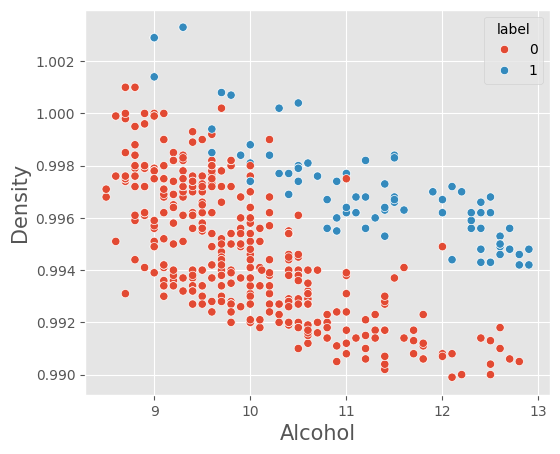

In [6]:
# Display the distribution of class 1 and 0 in a scatter plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x='alcohol', y='density', data=data, hue='label')
plt.xlabel('Alcohol', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

Split data into train and test sets

In [7]:
# Data splitting
from sklearn.model_selection import train_test_split

# Define features and target
X = data[['density', 'alcohol']]
y = data['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020, stratify=y
)

# Check the class distribution
print("Class distribution in train set:", Counter(y_train))
print("Class distribution in test set:", Counter(y_test))

Class distribution in train set: Counter({0: 338, 1: 78})
Class distribution in test set: Counter({0: 84, 1: 20})


Then, we try to build a classification model using logistic regression

In [8]:
# Classification - Logisitic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the model
logreg = LogisticRegression()

# Fitting model to train set
logreg.fit(X_train, y_train)

# Predict to test set
y_pred = logreg.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        84
           1       0.75      0.45      0.56        20

    accuracy                           0.87       104
   macro avg       0.82      0.71      0.74       104
weighted avg       0.86      0.87      0.85       104



Here the classification model will tend to perform well in one of the classes only, where the precision, recall, and f1 score values of the majority class have higher values. Let's try to deal with by implementing some of the following strategies.

**1. Feature Creation,** creating good new features will make it easier for classification models to distinguish between classes.

We will do the modeling process with adding polynomial features and see the changes.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

# Add a new polynomial feature
poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)

# Fitting into train set
poly.fit(X_train)

# Transform train and test set
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# Retrain logistic regression model
logreg.fit(X_train_poly, y_train)

# Predict to test set with polynomial features
y_pred_poly = logreg.predict(X_test_poly)

# Classification report
print(classification_report(y_test, y_pred_poly))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104



From illustration above, you can see the performance improvement of the logistic regression model.

**2. Random Oversampling & Undersampling:** are techniques commonly used in dealing with imbalanced datasets in machine learning.

Random oversampling aims to balance the class distribution by increasing the number of instances in the minority class. This is achieved by randomly duplication or replicating instance from that minority class until it reaches a desired balance with the majority class.

Advantages:

- Unlike undersampling, this method leads to no information loss.

Disadvantages:

- It increases the likelihood of overfitting since it replicates the minority class events.

In [ ]:
# We will use imblearn library
# pip install imblearn

In [10]:
# RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

# Initialize
ros = RandomOverSampler(random_state=42)

# Apply the oversampling to train set
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Check the class distribution
print("Class distribution before oversampling:", Counter(y_train))
print("Class distribution after oversampling:", Counter(y_resampled))

# Retrain logistic regression model
logreg.fit(X_resampled, y_resampled)

# Predict to test set
y_pred_resampled = logreg.predict(X_test)

# Classification report
print()
print(classification_report(y_test, y_pred_resampled))

Class distribution before oversampling: Counter({0: 338, 1: 78})
Class distribution after oversampling: Counter({0: 338, 1: 338})

              precision    recall  f1-score   support

           0       0.96      0.76      0.85        84
           1       0.46      0.85      0.60        20

    accuracy                           0.78       104
   macro avg       0.71      0.81      0.72       104
weighted avg       0.86      0.78      0.80       104



Random undersampling aims to balance the dataset by reducing the number of instances in the majority class to match the number of instances in the minority class. This is achieved by randomly selected instances are removed from the dataset, leaving a reduced dataset with a more balanced class distibution.

Advantages:

- It can help improve the runtime of the model and solve the memory problems.

Disadvantages:

- It can discard useful information about the data itself which could be necessary for building classifiers.

In [11]:
# RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

# Initialize
rus = RandomUnderSampler(random_state=42)

# Apply the undersampling to train set
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution
print("Class distribution before undersampling:", Counter(y_train))
print("Class distribution after undersampling:", Counter(y_resampled))

# Retrain logistic regression model
logreg.fit(X_resampled, y_resampled)

# Predict to test set
y_pred_resampled = logreg.predict(X_test)

# Classification report
print()
print(classification_report(y_test, y_pred_resampled))

Class distribution before undersampling: Counter({0: 338, 1: 78})
Class distribution after undersampling: Counter({0: 78, 1: 78})

              precision    recall  f1-score   support

           0       0.96      0.76      0.85        84
           1       0.46      0.85      0.60        20

    accuracy                           0.78       104
   macro avg       0.71      0.81      0.72       104
weighted avg       0.86      0.78      0.80       104



**3. Nearmiss,** refers fo a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.

There are three versions of the technique, [here](https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_illustration_nearmiss.html#sphx-glr-auto-examples-under-sampling-plot-illustration-nearmiss-py)

- version-1: Majority class examples with minimum average distance to three closest minority class examples.
- version-2: Majority class examples with minimum average distance to three furthest minority class examples.
- version-3: A nearest-neighbors is used to short-list samples from the majority class. Then, the sample with the largest average distance to the k-nearest-neigbors are selected.

In [12]:
# NearMiss
from imblearn.under_sampling import NearMiss

# Initialize
nearmiss = NearMiss(version=3, n_neighbors=3)

# Apply the nearmiss to train set
X_resampled, y_resampled = nearmiss.fit_resample(X_train, y_train)

# Check the class distribution
print("Class distribution before nearmiss:", Counter(y_train))
print("Class distribution after nearmiss:", Counter(y_resampled))

# Retrain logistic regression model
logreg.fit(X_resampled, y_resampled)

# Predict to test set
y_pred_resampled = logreg.predict(X_test)

# Classification report
print()
print(classification_report(y_test, y_pred_resampled))

Class distribution before nearmiss: Counter({0: 338, 1: 78})
Class distribution after nearmiss: Counter({1: 78, 0: 72})

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        84
           1       0.54      0.75      0.62        20

    accuracy                           0.83       104
   macro avg       0.73      0.80      0.76       104
weighted avg       0.86      0.83      0.84       104



**4. SMOTE**: it works by selecting a minority class instance a at random and finds its k nearest minority class neighbors.

How it work? The synthetic instance is then created by choosing one of the k nearest neigbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b. You can learn more details [here](https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_illustration_generation_sample.html).

In [13]:
# SMOTE
from imblearn.over_sampling import SMOTE

# Initialize
smote = SMOTE(random_state=42)

# Apply the smote to train set
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution
print("Class distribution before smote:", Counter(y_train))
print("Class distribution after smote:", Counter(y_resampled))

# Retrain logistic regression model
logreg.fit(X_resampled, y_resampled)

# Predict to test set
y_pred_resampled = logreg.predict(X_test)

# Classification report
print()
print(classification_report(y_test, y_pred_resampled))


Class distribution before smote: Counter({0: 338, 1: 78})
Class distribution after smote: Counter({0: 338, 1: 338})

              precision    recall  f1-score   support

           0       0.96      0.76      0.85        84
           1       0.46      0.85      0.60        20

    accuracy                           0.78       104
   macro avg       0.71      0.81      0.72       104
weighted avg       0.86      0.78      0.80       104



The following example attends to make a graphical comparison between the different resampling algorithms.

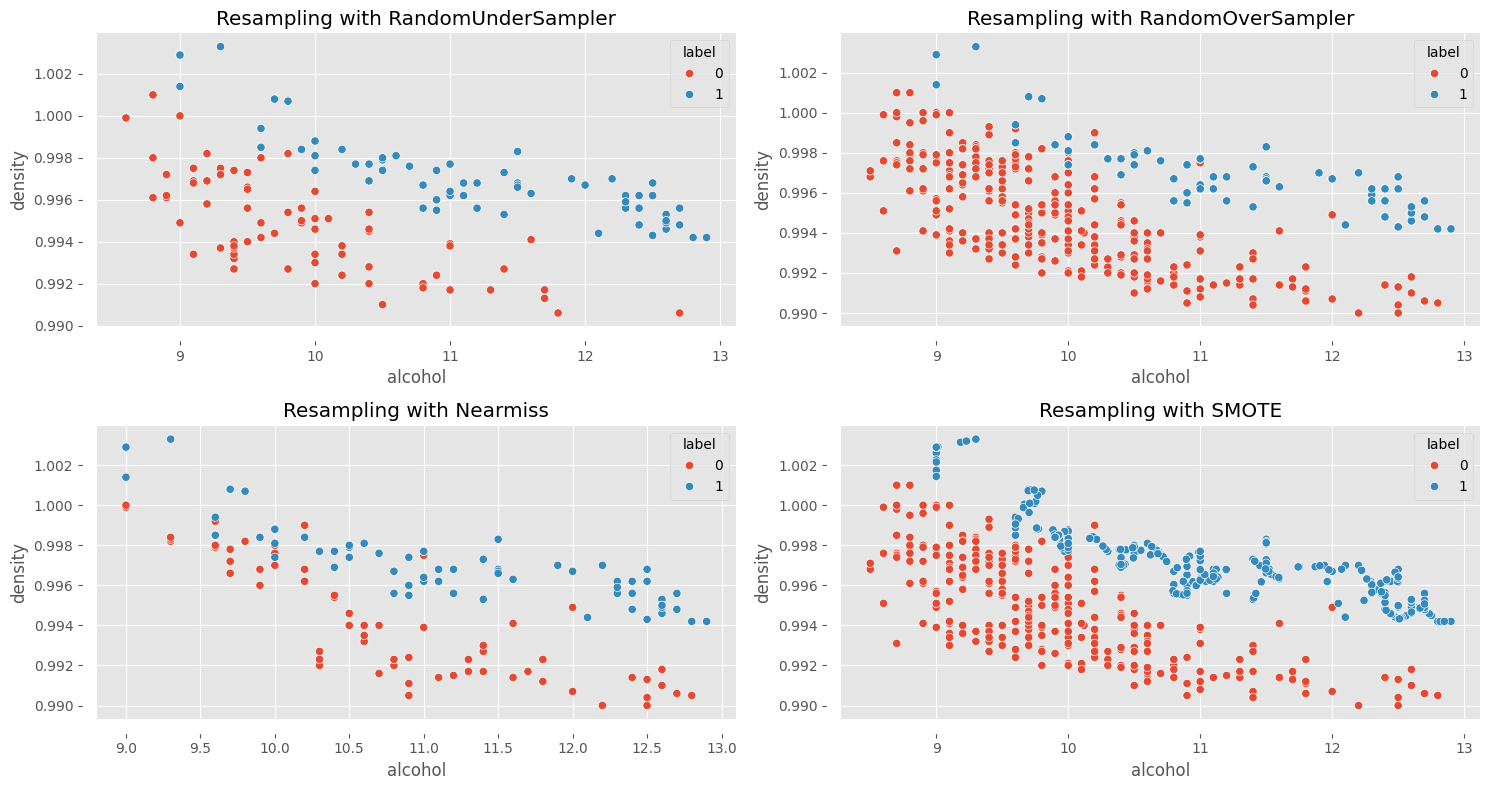

In [14]:
# Define function to create scatter plot visualization
def plot_resampling(X, y, sampler, ax, title=None):
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    sns.scatterplot(x=X_resampled['alcohol'], y=X_resampled['density'], hue=y_resampled, ax=ax)
    if title is None:
        title = f'Resampling with {sampler.__class__.__name__}'
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

# Determine which resampling method to compare
samplers=[
    RandomUnderSampler(random_state=42),
    RandomOverSampler(random_state=42),
    NearMiss(version=3),
    SMOTE(random_state=42)
]

# Set title for each graph
titles = [
    'Resampling with RandomUnderSampler',
    'Resampling with RandomOverSampler',
    'Resampling with Nearmiss',
    'Resampling with SMOTE',
]

# Figure size and axes configuration
fig, axes = plt.subplots(2, 2, figsize=(15,8))

# Show the plot
for ax, sampler, title in zip(axes.ravel(), samplers, titles):
    plot_resampling(X_train, y_train, sampler, ax, title=title)

fig.tight_layout()

**5. Penalize Model**, adding penalty weights injects intentional bias into the model. With penalty weights, model towards paying more attention to the minority class during training, thus creating a balance between the classes.

In [15]:
# Initialize the model
logreg_balanced = LogisticRegression(class_weight={0: 1, 1: 10})

# Fitting model to train set
logreg_balanced.fit(X_train, y_train)

# Predict to test set
y_pred_balanced = logreg_balanced.predict(X_test)

# Show the Classification report
print(classification_report(y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.98      0.52      0.68        84
           1       0.32      0.95      0.48        20

    accuracy                           0.61       104
   macro avg       0.65      0.74      0.58       104
weighted avg       0.85      0.61      0.64       104



**6. Using a Variety of Metrics**: Performance metrics may be needed that focus on the minority class, which is made challenging because it is the minority class where we lack observations required to train an effective model.

Let's look at some examples of different metrics from which we might choose.

**6.1 Balanced Accuracy**, it's the arithmetic mean of sensitivity and specificity.

In [16]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Calculate accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.3f}')
print(f'Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred):.3f}')

Accuracy score: 0.865
Balanced accuracy score: 0.707


**6.2 Geometric mean**, sensitivity and specificity can be combined into a single score that balances both concerns.

In [17]:
from sklearn.metrics import recall_score, precision_score

sensitivity = recall_score(y_test, y_pred, pos_label=1)
specificity = recall_score(y_test, y_pred, pos_label=0)
precision = precision_score(y_test, y_pred)

print(f'Geometric mean1: {np.sqrt(sensitivity*specificity):.3f}') # concern to both positive and negative classes
print(f'Geometric mean2: {np.sqrt(sensitivity*precision):.3f}') # concern only positive classes

Geometric mean1: 0.659
Geometric mean2: 0.581


**6.3 F-beta Measure**, an abstraction of the F-measure where the balance of precision and recall is controlled by a coefficient called beta.

In [18]:
from sklearn.metrics import fbeta_score

# Calculate f-beta score
print(f'F2 score: {fbeta_score(y_test, y_pred, beta=2):.3f}')       # recall is twice as important as precision
print(f'F0.5 score: {fbeta_score(y_test, y_pred, beta=0.5):.3f}')   # precision is 2 times more important than recall

F2 score: 0.489
F0.5 score: 0.662


**6.4 Brier Score**, it measures the mean squared difference between the predicted probability and the actual outcome.

In [19]:
from sklearn.metrics import brier_score_loss

# Predict probability
y_proba = logreg.predict_proba(X_test)[:, 1]

# Calculate Score
print(f'Brier Score: {brier_score_loss(y_test, y_proba):.3f}') # the smaller the better

Brier Score: 0.160


**Implementation Using Pipeline**

In [21]:
# combining resampling with all functions in Sklearn
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

# define model
logreg = LogisticRegression()

# define resampler
smote = SMOTE(random_state=0)

# pipeline
pipe_model=Pipeline([
    ('resampler', smote),
    ('modeling', logreg)
])

# cross validation

skfold = StratifiedKFold(n_splits=5)

cv_score = cross_val_score(
    estimator = pipe_model,
    X = X_train,
    y = y_train,
    cv= skfold,
    scoring = 'f1'
)

print(cv_score.mean())

0.543686339400625


**Note**:
for the next occasion, use the Pipeline function from imblearn, which has the following advantages:
- It can integrate the resampling process in imblearn with all functions in sklearn.
- It can distinguish between the train set and the test set, so the Pipeline will only perform resampling on the train set. (Remember, resampling is only performed on the train set for training; the test set should not be resampled because it reflects real-world conditions.)